In [31]:
%load_ext autoreload
%autoreload 2

# built-in libraries
import sys
import os
import random

# third party libraries
import matplotlib.pyplot as plt
import numpy as np
import tqdm
import torch
import torch.nn.functional as func


REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname(os.path.realpath('__file__')),".."))
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
SRC_DIR = os.path.join(REPO_ROOT,"src")
FAUST = os.path.join(REPO_ROOT,"datasets/faust")
PARAMS_FILE = os.path.join(REPO_ROOT, "model_data/FAUST10_pointnet.pt")

# repository modules
sys.path.insert(0, SRC_DIR)
import models
# import train
import ntrain
import dataset
import utils

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
from models.Origin_pointnet import PointNetCls
model = PointNetCls(k=10, feature_transform=False)
#print(model)

Load the data, organize in DataLoaders

In [33]:
from dataset.data_loaders import FaustDataset
train_dataset = FaustDataset(
    root=os.path.join(FAUST, r'raw'),
    classification=True,
    split='train')

test_dataset = FaustDataset(
    root=os.path.join(FAUST, r'raw'),
    classification=True,
    split='test',
    data_augmentation=False)

batchsize = 8  # was 8
trainLoader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batchsize,
                                           shuffle=True,
                                           num_workers=10)
testLoader = torch.utils.data.DataLoader(test_dataset,
                                           batch_size=20,
                                           shuffle=False,
                                           num_workers=10)

## Train data OR load the parameters

In [27]:
# train loop
loss_values, test_mean_loss, test_accuracy = ntrain.train(
                                                        train_data=trainLoader,
                                                        test_data=testLoader,
                                                        classifier=model,
                                                        batchSize=batchsize,
                                                        parameters_file=PARAMS_FILE,
                                                        epoch_number=100, # <- change here the number of epochs used for training
                                                        learning_rate=1e-3,
                                                        train=False)

80 20
classes 10


1it [00:18, 18.91s/it]


test mean loss: 2.3033156394958496  test_accuracy: 0.1


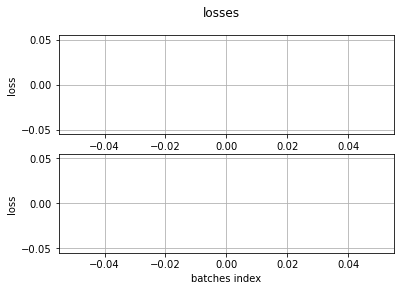

In [28]:
# show train results
print('test mean loss:',test_mean_loss,' test_accuracy:',test_accuracy)
loss_values = np.array(loss_values)
sliced_loss = loss_values[0::5]#sliced
fig, axs = plt.subplots(2)
fig.suptitle('losses')
axs[0].plot(np.arange(1,len(sliced_loss)+1,1), sliced_loss)
axs[1].plot(np.arange(1,len(loss_values)+1,1), loss_values)

axs[0].set(xlabel='5*batches index', ylabel='loss')
axs[0].grid()
axs[1].set(xlabel='batches index', ylabel='loss')
axs[1].grid()
plt.show()

In [34]:
# load parameters
model.load_state_dict(torch.load(PARAMS_FILE, map_location=DEVICE))
model.eval()

loss_values, test_mean_loss, test_accuracy = ntrain.train(
                                                        train_data=trainLoader,
                                                        test_data=testLoader,
                                                        classifier=model,
                                                        batchSize=batchsize,
                                                        parameters_file=PARAMS_FILE,
                                                        learning_rate=1e-3,
                                                        train=False)

print('test mean loss:',test_mean_loss,' test_accuracy:',test_accuracy)

0it [00:00, ?it/s]

80 20
classes 10


1it [00:08,  8.73s/it]

test mean loss: 0.35949277877807617  test_accuracy: 0.95


## Visualization procedures
These are some visualization procedures useful for displaying triangular meshes.

In [51]:
import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default='notebook'

def visualize(pos, faces, intensity=None):
  cpu = torch.device("cpu")
  if type(pos) != np.ndarray:
    pos = pos.to(cpu).clone().detach().numpy()
  if pos.shape[-1] != 3:
    raise ValueError("Vertices positions must have shape [n,3]")
  if type(faces) != np.ndarray:
    faces = faces.to(cpu).clone().detach().numpy()
  if faces.shape[-1] != 3:
    raise ValueError("Face indices must have shape [m,3]") 
  if intensity is None:
    intensity = np.ones([pos.shape[0]])
  elif type(intensity) != np.ndarray:
    intensity = intensity.to(cpu).clone().detach().numpy()

  x, z, y = pos.T
  i, j, k = faces.T

  mesh = go.Mesh3d(x=x, y=y, z=z,
            color='lightpink',
            intensity=intensity,
            opacity=1,
            colorscale=[[0, 'gold'],[0.5, 'mediumturquoise'],[1, 'magenta']],
            i=i, j=j, k=k,
            showscale=True)
  layout = go.Layout(scene=go.layout.Scene(aspectmode="data")) 

  #pio.renderers.default="plotly_mimetype"
  fig = go.Figure(data=[mesh],
                  layout=layout)
  fig.update_layout(
      autosize=True,
      margin=dict(l=20, r=20, t=20, b=20),
      paper_bgcolor="LightSteelBlue")
  fig.show()
    
def compare(pos1, faces1, pos2, faces2):
    n,m = pos1.shape[0], pos2.shape[0]
    tmpx = torch.cat([pos1, pos2],dim=0)
    tmpf = torch.cat([faces1, faces2+n], dim=0)
    color = torch.zeros([n+m],dtype=pos1.dtype, device=pos1.device)
    color[n:] = (pos1-pos2).norm(p=2,dim=-1)
    visualize(tmpx, tmpf,color)
    
def show_perturbation(adex):
    perturbed = adex.perturbed_pos.cpu()
    pos = adex.pos.cpu()
    p1 = adex.logits.cpu().detach().numpy()
    p2 = adex.perturbed_logits.cpu().detach().numpy()
    m = min([p1.min(), p2.min()])
    num_classes = p1.shape[1]

    x_ticks = np.array(range(num_classes), dtype=float)
    ax = plt.subplot(111)
    ax.bar(x_ticks - 0.2, (p1 - m)[0], width=0.4, color='b', align='center')
    ax.bar(x_ticks + 0.2, (p2 - m)[0], width=0.4, color='y', align='center')
    ax.legend(["standard", "perturbed towards " + str(adex.target.item())])
    ax.set_title("Class Probabilities with/without Perturbation")
    plt.show()

    color = (pos - perturbed).norm(p=2, dim=-1)
    visualize(perturbed, adex.faces, intensity=color)

# Adversarial Examples with Carlini&Wagner

In [52]:
# load data in different format for this code
traindata = dataset.FaustDataset(FAUST, device=DEVICE, train=True, test=False, transform_data=False)
testdata = dataset.FaustDataset(FAUST, device=DEVICE, train=False, test=True,  transform_data=False)


5
[0,1] ; c=1


100%|██████████| 150/150 [00:02<00:00, 57.58it/s]


[0,1] ; c=0.5


100%|██████████| 150/150 [00:02<00:00, 57.96it/s]


[0.5,1] ; c=0.75


100%|██████████| 150/150 [00:02<00:00, 58.75it/s]


[0.75,1] ; c=0.875


100%|██████████| 150/150 [00:02<00:00, 58.69it/s]


[0.75,0.875] ; c=0.8125


100%|██████████| 150/150 [00:02<00:00, 58.43it/s]


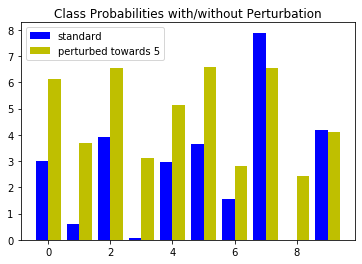

In [59]:
import adversarial.carlini_wagner as cw
from adversarial.carlini_wagner import CWBuilder, LowbandPerturbation

params = {
    CWBuilder.USETQDM:True,
    CWBuilder.MIN_IT:150,
    CWBuilder.LEARN_RATE:1e-4,
    CWBuilder.ADV_COEFF:1, # was 1
    CWBuilder.REG_COEFF:15, # was 1, what kind of reg is that??
    LowbandPerturbation.EIGS_NUMBER:40}

#choose random target
while True:
    i = random.randint(0, len(testdata)-1)
    target = random.randint(0, testdata.num_classes-1)
    # target = 6
    y = testdata[i].y.item()
    if y != target: break
mesh = testdata[i]
print(target)

# search for adversarial example
adex = cw.generate_adversarial_example(
    mesh=mesh, classifier=model, target=target,
    search_iterations=5,  # was 1
    lowband_perturbation=True,  # was true
    adversarial_loss="carlini_wagner",
    similarity_loss="local_euclidean",
    **params)

show_perturbation(adex)
compare(adex.pos, adex.faces, adex.perturbed_pos, adex.faces)
visualize(adex.pos, adex.faces)

In [10]:
import pyvista as pv

# plotting in pyvista:
perturbed = adex.perturbed_pos.cpu()
pos = adex.pos.cpu()
color = (pos - perturbed).norm(p=2, dim=-1)

mesh = pv.PolyData(perturbed, adex.faces)
p = pv.Plotter()
p.set_background(color='white')
# if not jet:
#     p.add_mesh(mesh, line_width=1, color='black', show_edges='True', edge_color='black', scalars=f)
# else:
# p.add_mesh(mesh, line_width=1, color='black', scalars=f, cmap='jet', lighting=True, clim=[-0.05, 0.05])
# p.add_mesh(arrows) # un-comment to add normals on top

p.show()

TypeError: Invalid input type